# Torchdiffeq with Deepchem

Author : [Anshuman Mishra](https://github.com/shivance)

## Colab

This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1x1_EexmiTk01dsAbdfopWKWbIGENiXC1?usp=sharing)


Before getting our hands dirty with </> , let us first understand little bit about what Neural ODEs are ?

#NeuralODEs and torchdiffeq

NeuralODE stands for "Neural Ordinary Differential Equation. You heard right. Let me guess . Your first impression of the word is : "Has it something to do with differential equations that we studied in 12th standard ?" 

Spot on ! Let's see the formal definition as stated by the original [paper](https://arxiv.org/pdf/1806.07366.pdf) : 



```
Neural ODEs are a new family of deep neural network models. Instead of specifying a discrete sequence of 
hidden layers, we parameterize the derivative of the hidden state using a neural network.

The output of the network is computed using a blackbox
differential equation solver.

These are continuous-depth models that have constant
memory cost, adapt their evaluation strategy to each input, and can explicitly trade
numerical precision for speed.
```


In simple words percieve NeuralODEs as yet another type of layer like Linear, Conv2D, MHA...



In this tutorial we will be using [torchdiffeq](https://github.com/rtqichen/torchdiffeq). This library provides ordinary differential equation (ODE) solvers implemented in PyTorch . The library provides nice clean API of ODE solvers for usage in deep learning applications. As the solvers are implemented in PyTorch, algorithms in this repository are fully supported to run on the GPU.


## What will you learn after completing this tutorial ?



1.   How to implement a Neural ODE in a Neural Network ?
2.   Using torchdiffeq with deepchem.
3. Ofcourse you'll be brushing up your PyTorch coding skills



### Installing Libraries

In [3]:
!pip install torchdiffeq
!pip install --pre deepchem

     |████████████████████████████████| 608 kB 5.2 MB/s 
     |████████████████████████████████| 15.7 MB 40.0 MB/s 
     |████████████████████████████████| 20.6 MB 58.7 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


### Import Libraries

In [6]:
import torch
import torch.nn as nn

from torchdiffeq import odeint
import math

import deepchem as dc
import matplotlib.pyplot as plt

Before diving into the core of this tutorial , let's first aquaint ourselves with usage of torchdiffeq. Let's solve following differential equation .

$ \frac{dz(t)}{dt} = f(t) = t $

when $z(0) = 0$

The process to do it by hand is :

$\int dz = \int tdt+C　\\\ z(t) = \frac{t^2}{2} + C$


 
Let's solve it using Neural ODE Solver `odeint` from torchdiffeq

In [9]:
def f(t,z):
  return t

z0 = torch.Tensor([0])
t = torch.linspace(0,2,100)
out = odeint(f, z0, t);

Let's plot our result .It should be a parabola (remember general equation of parabola as $x^2 = 4ay$ )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


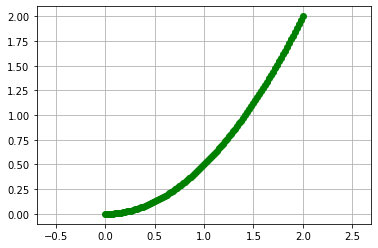

In [10]:
plt.plot(t, out, 'go--')
plt.axes().set_aspect('equal','datalim')
plt.grid()
plt.xlim(0,2)
plt.show()

Whoa that's amazing ! We just solved our first neural ODE.

## Load dataset

Let's load the Delaney solubility dataset. Our model will learn to predict the solubilities of molecules based on their extended-connectivity fingerprints (ECFPs) . For performance metrics we use [pearson_r2_score](https://deepchem.readthedocs.io/en/latest/api_reference/metrics.html#deepchem.metrics.pearson_r2_score) .

In [11]:
tasks, dataset, transformers = dc.molnet.load_delaney(featurizer='ECFP', splitter='random')
train_set, valid_set, test_set = dataset
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)

# Model

Let's see how to actually implement ODE Block. The ODE Block is a `nn.Module` that forms the dynamics of $\frac{dz}{dt} = f(t, z)$. 

The actual Neural ODE is constructed using ODE Block together with the normal Full-Connect layer and convolution layer.

In [12]:
from torchdiffeq import odeint_adjoint as odeadj


class ODEfunction(nn.Module):
  '''
  Like typical ODE , we have a function and We intgrate it wrt. some variable. Neural Networks are 
  Universal Function Approximators. They can approximate almost any function that exists out there.
  The most amazing thing with neural odes is : We don't know what the function is. So we learn it 
  from dataset . And the ode , differentiates and integrates it as per the need of the network.
  '''

  def __init__(self, dim):
    super(ODEfunction, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(dim,124),
        nn.ReLU(),
        nn.Linear(124,124),
        nn.ReLU(),
        nn.Linear(124,dim),
        nn.Tanh()
    )

  def forward(self, t, x):
    return self.model(x)

ODE Block treats the received input x as the initial value of the differential equation. ―― ʻODEfunc` is $ f $ that describes the dynamics of the system. --The integration interval of ODE Block is fixed at 0 ~ 1. And it returns the output of the layer at $ t = 1 $.

In [14]:
class ODEBlock(nn.Module):
  '''
  This is ODEBlock. Think of it as a wrapper over ODE Solver , so as to easily connect it with our neurons !
  '''
  def __init__(self, odefunction):
    super(ODEBlock, self).__init__()
    self.odefunction = odefunction
    self.integration_time = torch.Tensor([0,1]).float()

  def forward(self, x):
    self.integration_time = self.integration_time.type_as(x)
    out = odeadj(
        self.odefunction,
        x,
        self.integration_time
    )

    return out[1]


class ODENet(nn.Module):
  '''
  This is our main neural network that uses ODEBlock within a sequential module
  '''

  def __init__(self, in_dim, mid_dim, out_dim):
    super(ODENet, self).__init__()
    odefunction = ODEfunction(dim=mid_dim)
    self.fc1 = nn.Linear(in_dim, mid_dim)
    self.relu1 = nn.ReLU(inplace=True)
    self.norm1 = nn.BatchNorm1d(mid_dim)
    self.ode_block = ODEBlock(odefunction)
    self.dropout = nn.Dropout(0.4)
    self.norm2 = nn.BatchNorm1d(mid_dim)
    self.fc2 = nn.Linear(mid_dim, out_dim)

  def forward(self, x):
    batch_size = x.shape[0]
    x = x.view(batch_size, -1)

    out = self.fc1(x)
    out = self.relu1(out)
    out = self.norm1(out)
    out = self.ode_block(out)
    out = self.norm2(out)
    out = self.dropout(out)
    out = self.fc2(out)

    return out

## Time to Train

We train our model for 20 epochs, with L2 as Loss Function.

In [13]:
# Like mentioned before one can use GPUs with PyTorch and torchdiffeq
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = ODENet(in_dim=1024, mid_dim=1000, out_dim=1).to(device)
model = dc.models.TorchModel(model, dc.models.losses.L2Loss())

model.fit(train_set, nb_epoch=20)

print('Training set score : ', model.evaluate(train_set,[metric]))
print('Test set score : ', model.evaluate(test_set,[metric]))

Training set score :  {'pearson_r2_score': 0.9629426947607878}
Test set score :  {'pearson_r2_score': 0.7681266907039555}


# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!